<a href="https://colab.research.google.com/github/milicasopalovic/RI_rokovi/blob/main/inicijalni_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://gitlab.com/milicasopalovic/ip2-projekat.git

In [ ]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import load_img, img_to_array, save_img, image_dataset_from_directory
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from collections import Counter
import cv2
import imghdr
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [ ]:
import tensorflow as tf


train_dir = './ip2-projekat/skup_podataka_original/trening'
test_dir = './ip2-projekat/skup_podataka_original/test'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,  # 20% za validaciju
    subset='validation',
    seed=123
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='categorical'
)




In [ ]:
imena_klasa = train_dataset.class_names

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_names = train_dataset.class_names
num_classes = len(class_names)

broj_uzoraka_po_klasi = np.zeros(num_classes, dtype=int)
for _, labels in train_dataset:
    broj_uzoraka_po_klasi += np.sum(labels.numpy(), axis=0).astype(int)

print("Broj uzoraka po klasama:", broj_uzoraka_po_klasi)

tezine_klasa = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=np.concatenate([
        np.full(n, i) for i, n in enumerate(broj_uzoraka_po_klasi)
    ])
)
tezine_klasa = dict(enumerate(tezine_klasa))
print("Težine klasa:", tezine_klasa)


Broj uzoraka po klasama: [ 32  38  15  15  10   3  44  24  54  32  20  24  41  30  30  30  15  55
  59  30 129  19  14  18  14  12  16  14  16  13  14  14  16  17  15  30
  44]
Težine klasa: {0: 0.8581081081081081, 1: 0.7226173541963016, 2: 1.8306306306306306, 3: 1.8306306306306306, 4: 2.745945945945946, 5: 9.153153153153154, 6: 0.6240786240786241, 7: 1.1441441441441442, 8: 0.5085085085085085, 9: 0.8581081081081081, 10: 1.372972972972973, 11: 1.1441441441441442, 12: 0.6697429136453527, 13: 0.9153153153153153, 14: 0.9153153153153153, 15: 0.9153153153153153, 16: 1.8306306306306306, 17: 0.49926289926289924, 18: 0.46541456710948237, 19: 0.9153153153153153, 20: 0.21286402681751518, 21: 1.4452347083926032, 22: 1.9613899613899615, 23: 1.5255255255255256, 24: 1.9613899613899615, 25: 2.2882882882882885, 26: 1.7162162162162162, 27: 1.9613899613899615, 28: 1.7162162162162162, 29: 2.1122661122661124, 30: 1.9613899613899615, 31: 1.9613899613899615, 32: 1.7162162162162162, 33: 1.6152623211446742, 34

Ovaj kod definiše konvolucijsku neuronsku mrežu (CNN) za klasifikaciju slika. Mreža koristi tri konvoluciona sloja, pri čemu svaki sloj koristi ReLU aktivaciju i prati se sa MaxPooling slojevima za smanjenje dimenzionalnosti. Na kraju, koristi se GlobalAveragePooling sloj za smanjenje prostornog opsega podataka pre nego što se šalju u gusto povezane slojeve. Poslednji sloj je softmax aktivacija sa 37 jedinica, koja je pogodna za višeklasnu klasifikaciju sa 37 kategorija. Mreža je kompilirana sa Adam optimizatorom i koristi kategorijsku unakrsnu entropiju kao funkciju gubitka, a metrika koja se prati je tačnost.

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(37, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
epohe = 50
history = model.fit(
    train_dataset,
    class_weight=tezine_klasa,
    validation_data = validation_dataset,
    epochs=epohe
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.3513 - loss: 1.9425 - val_accuracy: 0.3478 - val_loss: 2.6563
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4022 - loss: 1.8113 - val_accuracy: 0.3715 - val_loss: 2.5865
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.4093 - loss: 1.7647 - val_accuracy: 0.3004 - val_loss: 2.7302
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4102 - loss: 1.7799 - val_accuracy: 0.3439 - val_loss: 2.5484
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.3911 - loss: 1.7636 - val_accuracy: 0.4071 - val_loss: 2.5113
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.4534 - loss: 1.6317 - val_accuracy: 0.3202 - val_loss: 2.7385
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4260 - loss: 1.6130 - val_accuracy: 0.4032 - val_loss: 2.6088
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4924 - loss: 1.4126 - val_accuracy: 0.3676 - v

Iako je preciznost na trening skupu bila visoka (81%), model pokazuje značajno nižu tačnost (50.26%) i viši gubitak (2.97) na test skupu, što sugeriše na overfitting ili nezadovoljavajuću generalizaciju na novim podacima.

In [ ]:
gubitak, preciznost = model.evaluate(test_dataset)
print("Preciznost na test skupu:", preciznost)
print("Gubitak na test skupu:", gubitak)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5140 - loss: 3.1673
Preciznost na test skupu: 0.5026269555091858
Gubitak na test skupu: 2.966799020767212


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

stvarno = []
for _, labels in test_dataset:
    stvarno.extend(np.argmax(labels, axis=1))

# Predikcije modela za test skup
predikcije = np.argmax(model.predict(test_dataset), axis=-1)

# Izračunavanje matrice konfuzije
matrica_konfuzije = confusion_matrix(stvarno, predikcije)

print(matrica_konfuzije)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
[[1 0 0 ... 1 2 1]
 [1 2 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 1]
 [1 1 0 ... 2 1 0]
 [1 0 0 ... 2 2 1]]


Klase sa dobrom klasifikacijom: Neke klase, kao što su human i cardassian, pokazuju relativno dobru tačnost, ali i dalje postoji određeni broj grešaka.

Problematične klase: Klase poput bolian, brikar, jem'Hadar, i tellarite imaju visoku stopu konfuzije sa drugim klasama, što ukazuje na to da model ne uspeva da pravilno razdvoji ove klase.

Generalni trend grešaka: Model ima tendenciju da greši u korist dominantnijih klasa, dok ređe klase često bivaju pogrešno klasifikovane. Takođe, vizuelno slične ili semantički bliske klase su često pomešane.

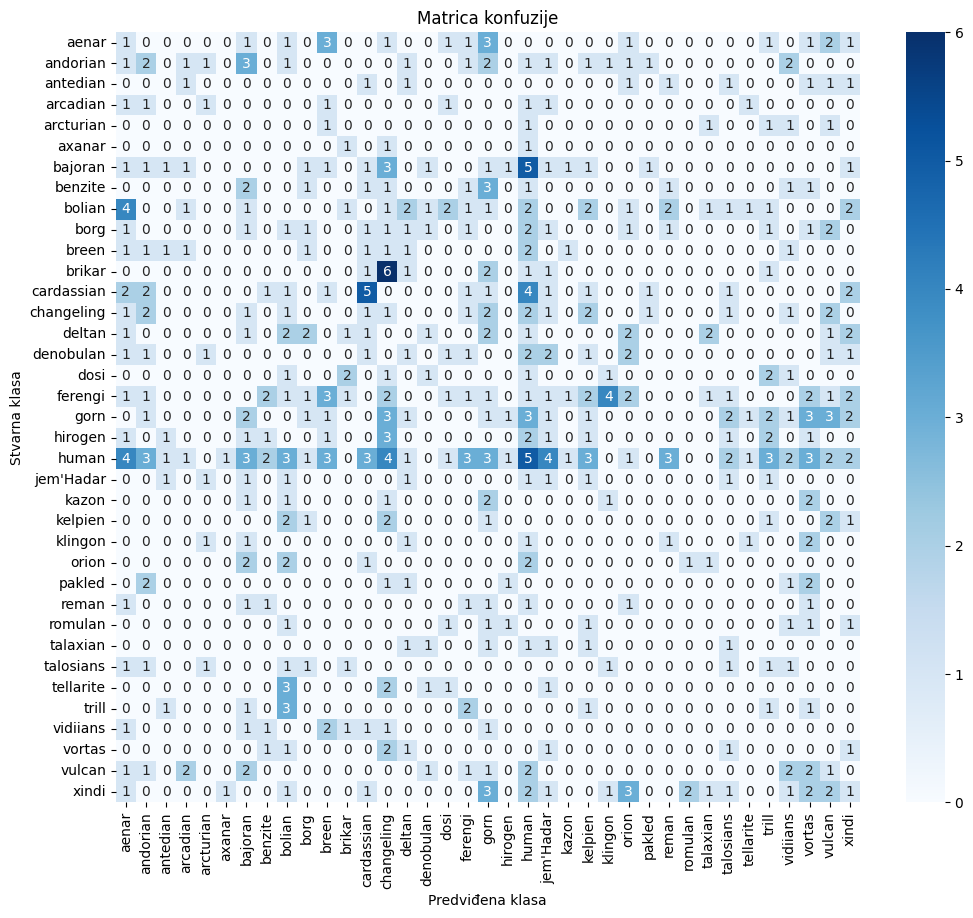

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definisanje svih klasa
imena_klasa_sortirano = sorted(imena_klasa)  # Sortiranje klasa

# Kreiranje DataFrame-a za matricu konfuzije
matrica_df = pd.DataFrame(matrica_konfuzije, index=imena_klasa_sortirano, columns=imena_klasa_sortirano)

# Prikazivanje matrice konfuzije
plt.figure(figsize=(12, 10))
sns.heatmap(matrica_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Sada cu isti model trenirati na vestacki generisanim podacima kako bih uporedila njegove performanse.

In [ ]:
import tensorflow as tf



train_dir = './ip2-projekat/skup_podataka_vestacki/trening'
test_dir = './ip2-projekat/skup_podataka_vestacki/test'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=123
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=123

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='categorical'
)




Found 6231 files belonging to 37 classes.
Using 4985 files for training.
Found 6231 files belonging to 37 classes.
Using 1246 files for validation.
Found 2843 files belonging to 37 classes.


In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(37, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
epohe = 50
history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs=epohe
)

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.1939 - loss: 2.9559 - val_accuracy: 0.2352 - val_loss: 2.6642
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - accuracy: 0.2571 - loss: 2.6208 - val_accuracy: 0.3154 - val_loss: 2.4569
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.2928 - loss: 2.4676 - val_accuracy: 0.3764 - val_loss: 2.1881
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.3534 - loss: 2.2197 - val_accuracy: 0.3925 - val_loss: 2.0302
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.3850 - loss: 2.0644 - val_accuracy: 0.4077 - val_loss: 2.0599
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.4226 - loss: 1.9347 - val_accuracy: 0.4783 - val_loss: 1.8183
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.4494 - loss: 1.8365 - val_accuracy: 0.4904 - val_loss: 1.5999
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.4938 - loss: 1.6512 - v

In [ ]:
gubitak, preciznost = model.evaluate(test_dataset)
print("Preciznost na test skupu:", preciznost)
print("Gubitak na test skupu:", gubitak)

89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6214 - loss: 3.2719
Preciznost na test skupu: 0.6257474422454834
Gubitak na test skupu: 3.3297793865203857


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Stvarne vrednosti za test skup
stvarno = []
for _, labels in test_dataset:
    stvarno.extend(np.argmax(labels, axis=1))

# Predikcije modela za test skup
predikcije = np.argmax(model.predict(test_dataset), axis=-1)

# Izračunavanje matrice konfuzije
matrica_konfuzije = confusion_matrix(stvarno, predikcije)

print(matrica_konfuzije)


89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step
[[ 4  6  2 ...  0  0  9]
 [ 9  2  2 ...  0  4 12]
 [ 4  1  2 ...  1  0  3]
 ...
 [ 1  1  0 ...  0  0  3]
 [ 5  0  0 ...  0  1  8]
 [ 3  6  0 ...  1  3 11]]


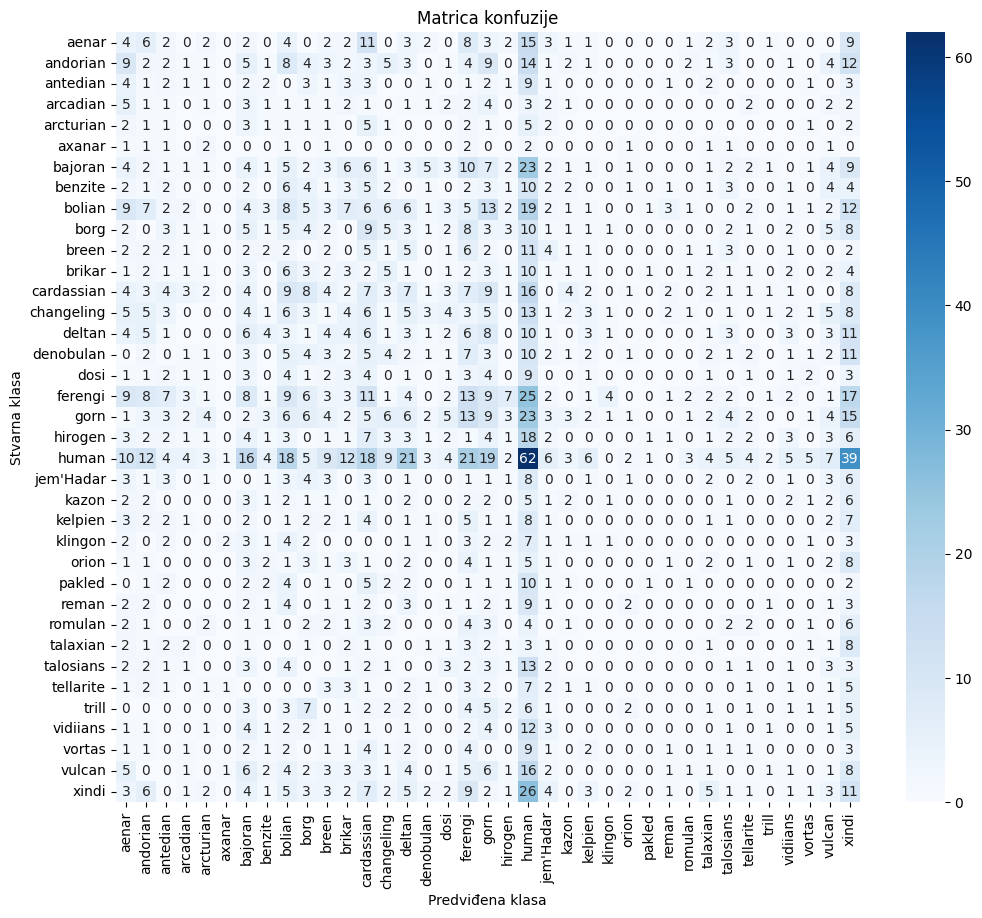

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definisanje svih klasa
imena_klasa_sortirano = sorted(imena_klasa)  # Sortiranje klasa

# Kreiranje DataFrame-a za matricu konfuzije
matrica_df = pd.DataFrame(matrica_konfuzije, index=imena_klasa_sortirano, columns=imena_klasa_sortirano)

# Prikazivanje matrice konfuzije
plt.figure(figsize=(12, 10))
sns.heatmap(matrica_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()